# Non-linear PYMC3

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from theano import shared
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
import pysdaza as sd

/Users/sdaza/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
sd.

In [85]:
df = pd.read_stata('../data/LA_uncertainty_2016.dta')

In [86]:
df = df.loc[:,['gdp_pc', 'year', 'ctry', 'median_est']]

In [87]:
df.columns = ['gdp', 'year', 'country', 'le']

In [88]:
df.dropna(inplace=True)

In [89]:
year = (df.year <1950).values

In [90]:
le = df['le']

In [91]:
gdp = df['gdp']

In [92]:
lem  = le / (1.05 * np.max(le))

In [93]:
lem49 = lem[year]
gdp49 = gdp[year]
lem50 = lem[~year]
gdp50 = gdp[~year]

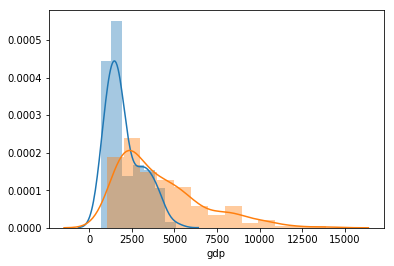

In [207]:
sns.distplot(gdp49)
sns.distplot(gdp50); # overlap?

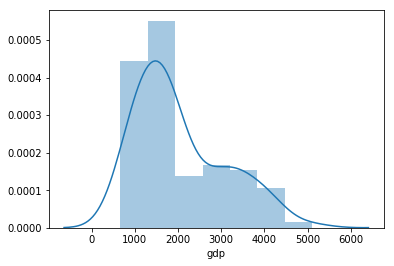

In [205]:
sns.distplot

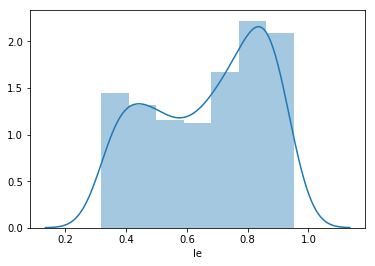

In [95]:
sns.distplot(lem)

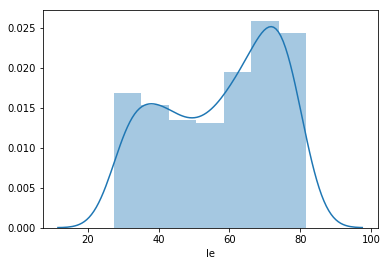

In [96]:
sns.distplot(le)

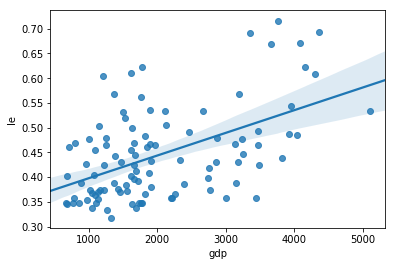

In [97]:
sns.regplot(gdp49, lem49)

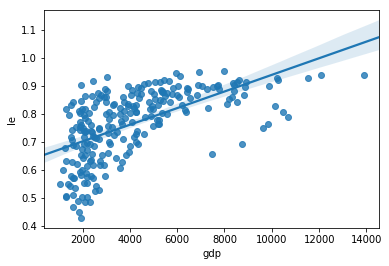

In [98]:
sns.regplot(gdp50, lem50)

# logistic non-linear model 

```
logfnS<-function(gdp.pc,alpha,beta,C){
  alpha / (1 + exp( beta + exp(log(C) * gdp.pc )))
 }
```

In [159]:
np.std(lem49)

In [295]:
gdp49_shared = shared(gdp49.values)

In [298]:
with pm.Model() as logistic49:
    beta = pm.Normal('beta',4.02, 0.1)
    alpha = pm.Normal('alpha',46, 0.1)
    C = pm.Uniform('C', 0.5, 1.)

    gauss = pm.Deterministic('gauss', alpha / (1 + tt.exp( beta + tt.exp(tt.log(C) * gdp49_shared))))

    y = Normal('y', mu=gauss, sd=0.1, observed=lem49)

    start=pm.find_MAP()
    step=pm.NUTS()
    trace49=pm.sample(2000,start=start, tune=2000)

logp = -586.35, ||grad|| = 3,003.6: 100%|██████████| 10/10 [00:00<00:00, 948.04it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C_interval__, alpha, beta]
INFO:pymc3:NUTS: [C_interval__, alpha, beta]
100%|██████████| 4000/4000 [00:10<00:00, 381.42it/s]


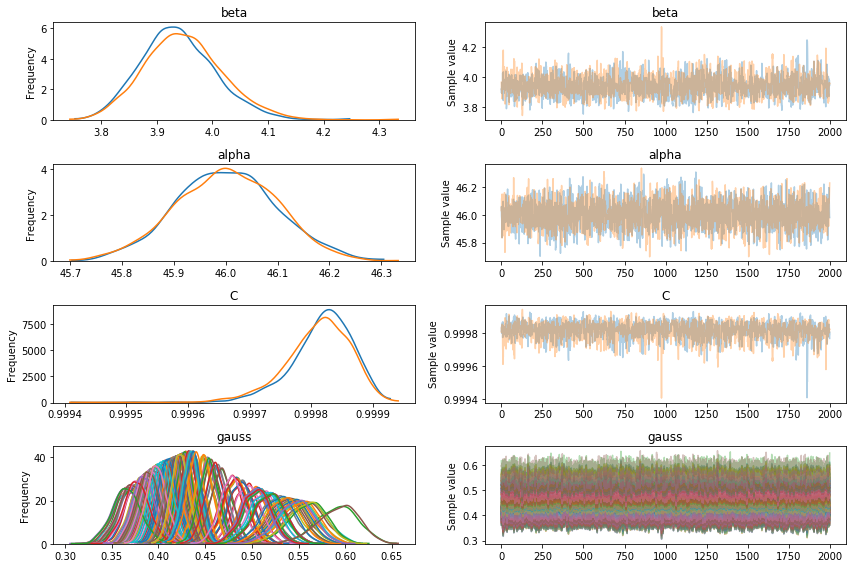

In [299]:
pm.traceplot(trace49);

In [300]:
gdp49.describe()

count     103.000000
mean     2040.395630
std      1034.661743
min       665.647339
25%      1237.973145
50%      1712.121216
75%      2764.713989
max      5102.309570
Name: gdp, dtype: float64

In [273]:
# gdp49_range = np.arange(600.,5200., 10.)
# gdp49_shared.set_value(np.array(gdp49_range, dtype="float32"))

In [301]:
with logistic49:
    post_pred49 = pm.sample_ppc(trace49, samples=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2305.65it/s]


In [389]:
def plot_predictions(trace, x, y, outcome):
    mu_mean = trace[outcome]
    mu_hpd = pm.hpd(mu_mean)

    plt.plot(x, y, 'C0o')
    idx = np.argsort(x)
    plt.plot(x[idx], mu_mean.mean(0)[idx], 'C2', linewidth=1)
    
    plt.fill_between(x[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], 
                     color='C2', alpha=0.25)
    plt.show()

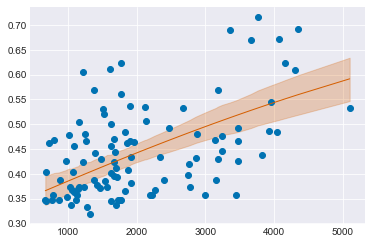

In [388]:
plot_predictions(trace49, gdp49.values, lem49.values, 'gauss')

In [468]:
pm.stats.waic(model=logistic49, trace=trace49)

WAIC_r(WAIC=-217.5847859519769, WAIC_se=9.0446895020392759, p_WAIC=1.193180904867617)

In [469]:
with pm.Model() as logistic50:
    beta = pm.Normal('beta',2.0, 0.5)
    alpha = pm.Normal('alpha',10.0, 0.5)
    C = pm.Uniform('C', 0.5, 1.)

    gauss= pm.Deterministic('gauss', alpha / (1 + np.exp( beta + np.exp(np.log(C) * gdp50))))

    y = Normal('y', mu=gauss, sd=0.1, observed=lem50)

    start=pm.find_MAP()
    step=pm.NUTS()
    trace50=pm.sample(2000,start=start, tune=1000)

logp = 150.66, ||grad|| = 0.017224: 100%|██████████| 20/20 [00:00<00:00, 1651.24it/s]  
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [C_interval__, alpha, beta]
INFO:pymc3:NUTS: [C_interval__, alpha, beta]
100%|██████████| 3000/3000 [00:17<00:00, 166.71it/s]
The acceptance probability does not match the target. It is 0.925176226615, but should be close to 0.8. Try to increase the number of tuning steps.


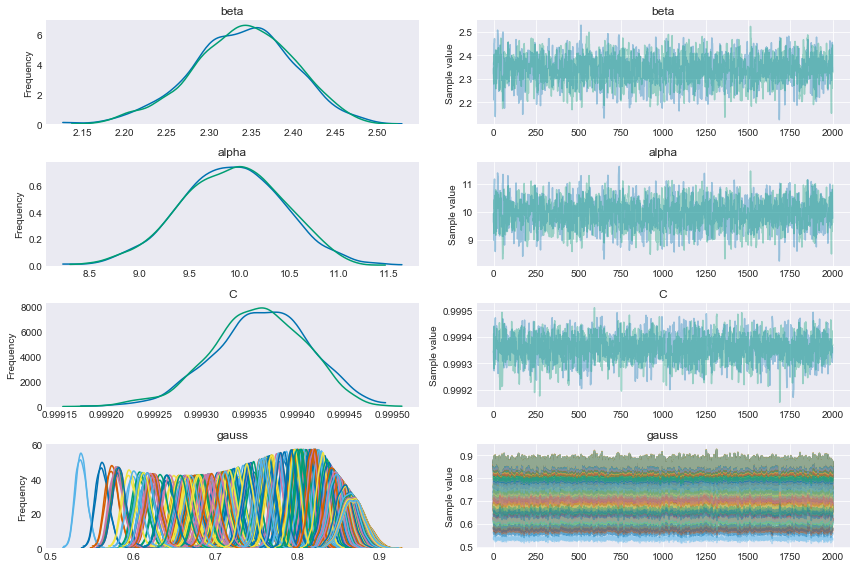

In [399]:
pm.traceplot(trace50);

In [282]:
# pm.gelman_rubin(trace50)

In [383]:
with logistic50:
    post_pred50 = pm.sample_ppc(trace50, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2022.68it/s]


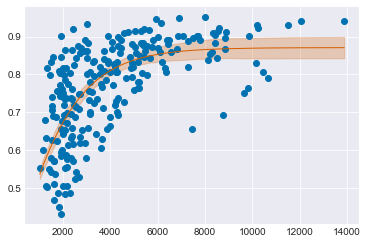

In [470]:
plot_predictions(trace50, gdp50.values, lem50.values, 'gauss')

In [471]:
pm.stats.waic(model=logistic50, trace=trace50)

WAIC_r(WAIC=-453.42523013806726, WAIC_se=18.819521664322064, p_WAIC=1.7866340411141604)

In [401]:
# plt.errorbar(x=gdp50, y=np.asarray(post_pred50['y']).mean(axis=0), 
#              yerr=np.asarray(post_pred50['y']).std(axis=), 
#              linestyle='', marker='o', alpha=0.1)
# plt.scatter(x=gdp50, y=lem50, marker='o', alpha=0.2, color='g')
# # plt.plot(log_dose, deaths, 'o')
# plt.xlabel('gdp',size=11)
# plt.ylabel('LE',size=11);

# Boxcox

In [450]:
xt, ld = stats.boxcox(lem50)

In [447]:
def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

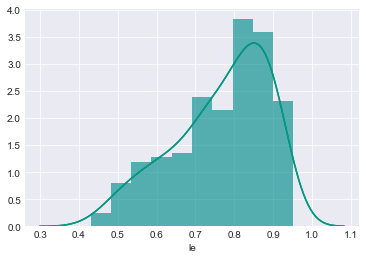

In [458]:
sns.distplot(invboxcox(xt,ld))
sns.distplot(lem50)

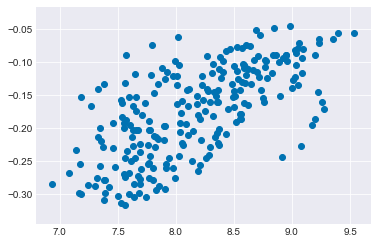

In [472]:
plt.scatter(np.log(gdp50), xt)

In [425]:
sns.distplot(xt)
sns.distplot(lem50)

In [463]:
with pm.Model() as logistic50_bx:
    beta = pm.Normal('beta',0, 0.2)
    alpha = pm.Normal('alpha', 0, 0.2)

    gauss= pm.Deterministic('gauss', alpha + beta * np.log(gdp50))
    y = Normal('y', mu=gauss, sd=0.1, observed=lem50)

    start=pm.find_MAP()
    step=pm.NUTS()
    trace50_bx=pm.sample(2000,start=start, tune=1000)

TypeError: Deterministic() got an unexpected keyword argument 'transform'

In [437]:
with logistic50_bx:
    post_pred50_bx = pm.sample_ppc(trace50_bx, samples=100)

100%|██████████| 100/100 [00:00<00:00, 1412.25it/s]


In [438]:
post_pred50_bx

{'y': array([[-0.22481701, -0.34389798, -0.23281829, ..., -0.22436208,
         -0.03839034, -0.26457597],
        [-0.24572982, -0.30894236, -0.28380971, ..., -0.29079566,
         -0.0246764 , -0.1112487 ],
        [-0.3132142 , -0.26231683, -0.30606968, ..., -0.19516633,
         -0.32285679, -0.09823026],
        ..., 
        [-0.27123965, -0.35984783, -0.1003825 , ..., -0.27830156,
         -0.10547756, -0.20943822],
        [-0.19649681, -0.177854  , -0.25932646, ..., -0.05475754,
         -0.15806659, -0.18450975],
        [-0.10856876, -0.15239659, -0.00273599, ..., -0.17442816,
         -0.13466291,  0.04984231]])}

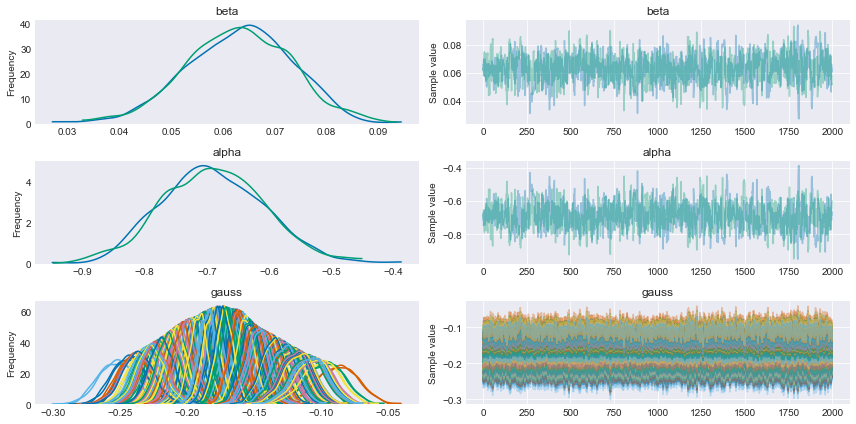

In [429]:
traceplot(trace50_bx);

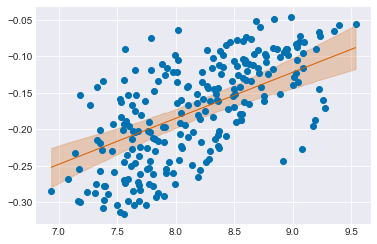

In [430]:
plot_predictions(trace50_bx, np.log(gdp50.values), y_bx, 'gauss')